In [1]:
import pandas as pd
import numpy as np
import glob
import plotly.graph_objects as go

In [2]:
# functions written by Mitali and Girish in 2024
# adapted by Tanvi Deora, April 2025

def angle(x1, y1, x2, y2, x3, y3, x4, y4):
    """
    Calculate the angles theta and phi between two vectors

    Parameters:
        x1,y1 (float) : The coordinates of point 1.
        x2,y2 (float) : The coordinates of point 2.
        x3,y3 (float) : The coordinates of point 3.
        x4,y4 (float) : The coordinates of point 4.

    Returns:
        angle (float) : The angle (in degrees) between the vector joining point1 & point 2 and vector joining point3 & 4

    Dependencies:
        - numpy (np): Required for numerical computations and array operations.
    """

    # Convert the input coordinates to NumPy arrays for vector operations
    a = np.array([x1,y1]) # COM of leading (chasee) fly
    b = np.array([x2,y2]) # COM of lagging (chaser) fly
    c = np.array([x3,y3]) # 0,0
    d = np.array([x4,y4]) # unit tangent vector for chaser
    

    # Calculate the vectors
    ba = b - a
    dc = d - c 

    # Calculate the theta angle (angle in XY plane)
    angle = np.degrees(np.arctan2(np.cross(ba, dc), np.dot(ba, dc)))

#     # Calculate the phi angle (angle in ZY plane) 
#     phi = np.degrees(np.arctan2(np.cross(ab[[0, 2]], cd[[0, 2]]), np.dot(ab[[0, 2]], cd[[0, 2]])))

    return angle

In [3]:
# files = glob.glob('./Data/Outputs/Sampled_1k/COM/*_smoothened_*COM.csv')
files = glob.glob('../dataFolders/MuscaChasingMusca/Outputs\\test_spiral_COM.csv')

In [4]:
# info = pd.read_csv('./Data/Outputs/Raw_xyz_points/metadata.csv')
# info

In [36]:
len(chasee_COM), len(unit_tangents_yz)

(450, 449)

In [41]:
for f in files:
    name = f.split('\\')[-1][:-4]
    df = pd.read_csv(f)
    
    framerate = 1000 # for sequences sampled at 1k
#     framerate = [row['framerate'] for ind, row in info.iterrows() if row['filename'][:-10] in f.split('\\')[-1]][0] 
    
    # get points to compute error angles
    
    # Method 2 - use tangent at a given point on the chaser trajectory to get heading vector, at the instants measured 
    # on the video
    
    # point connecting the the chaser and chasee
    # ignore the first frame when analysis the relative positions
    chasee_COM = df.loc[1:, ['chasee_com_x', 'chasee_com_y', 'chasee_com_z']]
    chaser_COM = df.loc[1:, ['chaser_com_x', 'chaser_com_y', 'chaser_com_z']]
    
    # heading vector for chaser
    # compute tangent at each point on the chaser trajectory
    # Store unit tangent vectors
    unit_tangent_xy = []
    unit_tangent_yz = []
    x_vals = np.diff(df.loc[:, 'chaser_com_x'])
    y_vals = np.diff(df.loc[:, 'chaser_com_y'])
    z_vals = np.diff(df.loc[:, 'chaser_com_z']) 
    
    # Approximate slope using central differences
    for i in range(len(x_vals)):
        x0, y0, z0 = x_vals[i], y_vals[i], z_vals[i]

        # Compute slope using finite difference
        if 0 < i < len(x_vals) - 1:
            dx = x_vals[i+1] - x_vals[i-1]
            dy = y_vals[i+1] - y_vals[i-1]
            dz = z_vals[i+1] - z_vals[i-1]
        elif i == 0:
            dx = x_vals[i+1] - x_vals[i]
            dy = y_vals[i+1] - y_vals[i]
            dz = z_vals[i+1] - z_vals[i]
        else:  # i == last index
            dx = x_vals[i] - x_vals[i-1]
            dy = y_vals[i] - y_vals[i-1]
            dz = z_vals[i] - z_vals[i-1]
        
        #################### Normalize to unit vector for the XY plane #######################
        norm_xy = np.sqrt(dx**2 + dy**2)
        if norm_xy == 0:
            unit_dx, unit_dy = 0.0, 0.0  # Avoid division by zero
        else:
            unit_dx = dx / norm_xy
            unit_dy = dy / norm_xy
            
        unit_tangent_xy.append({'x0': x0, 'y0': y0, 'unit_x': unit_dx, 'unit_y' :unit_dy})
        
        #################### Normalize to unit vector for the YZ plane #######################
        norm_yz = np.sqrt(dy**2 + dz**2)
        if norm_yz == 0:
            unit_dy, unit_dz = 0.0, 0.0  # Avoid division by zero
        else:
            unit_dy = dy / norm_yz
            unit_dz = dz / norm_yz
            
        unit_tangent_yz.append({'y0': y0, 'z0': z0, 'unit_y': unit_dy, 'unit_z' :unit_dz})
        
        
    unit_tangents_xy = pd.DataFrame(unit_tangent_xy)
    unit_tangents_yz = pd.DataFrame(unit_tangent_yz)
    
    
# #     #Method 3 - use the last two points and assume a straight vector joining those points
# #     chaser_com_current = df.loc[:-1, ['chaser_com_x', 'chaser_com_y', 'chaser_com_z']]
# #     chaser_com_previous = df.loc[1:,['chaser_com_X', 'chaser_com_y', 'chaser_com_z']]
    
    # check if you NaN anywhere!
    for all_vectors in [chasee_COM, 
                        chaser_COM, 
                        unit_tangents_xy['unit_x'], unit_tangents_xy['unit_y'], 
                        unit_tangents_yz['unit_y'], unit_tangents_yz['unit_z']]:
        print(all_vectors.isnull().values.any())
    
        
    chase_theta = []
    chase_phi = []
    chaser_angles_xy = []
    chaser_angles_yz = []
    
    for ind, _ in chasee_COM[:-1].iterrows():
#         print(ind)
        pt1 = chasee_COM.loc[ind, :]
        pt2 = chaser_COM.loc[ind, :]
        
        pt3 = [0,0]
        pt4 = unit_tangents_xy.loc[ind, ['unit_x', 'unit_y']]
        pt5 = unit_tangents_yz.loc[ind, ['unit_y', 'unit_z']]
        
        
        theta = angle(
            pt1['chasee_com_x'], pt1['chasee_com_y'],
            pt2['chaser_com_x'], pt2['chaser_com_y'],
            pt3[0], pt3[1],
            pt4[0], pt4[1]
            )
        phi = angle(
            pt1['chasee_com_x'], pt1['chasee_com_y'],
            pt2['chaser_com_x'], pt2['chaser_com_y'],
            pt3[0], pt3[1],
            pt5[0], pt5[1]
            )
        
        chaser_angle_xy = angle(
            0, 0,
            unit_tangents_xy.loc[ind -1, 'unit_x'], unit_tangents_xy.loc[ind-1, 'unit_y'],
            0, 0,
            unit_tangents_xy.loc[ind, 'unit_x'], unit_tangents_xy.loc[ind, 'unit_y'] 
        )
        
        chaser_angle_yz = angle(
            0, 0,
            unit_tangents_yz.loc[ind -1, 'unit_y'], unit_tangents_yz.loc[ind-1, 'unit_z'],
            0, 0,
            unit_tangents_yz.loc[ind, 'unit_y'], unit_tangents_yz.loc[ind, 'unit_z']
        )
           
        chase_theta.append(theta)
        chase_phi.append(phi)
        chaser_angles_xy.append(chaser_angle_xy)
        chaser_angles_yz.append(chaser_angle_yz)
        
          
#     #Calculating angular velocity of Chasee and chaser
#     angvel_chase_theta = np.diff(chase_theta)*framerate
#     angvel_chase_phi = np.diff(chase_phi)*framerate
#     angvel_chase_theta = np.append(angvel_chase_theta, np.repeat(np.nan, 1))
#     angvel_chase_phi = np.append(angvel_chase_phi, np.repeat(np.nan, 1))
    
#     #Calculating angular accerelation of Chasee and chaser
#     angacc_chase_theta = np.diff(angvel_chase_theta)
#     angacc_chase_phi = np. diff(angvel_chase_phi)
#     angacc_chase_theta = np.append(angacc_chase_theta, np.repeat(np.nan, 1))
#     angacc_chase_phi = np.append(angacc_chase_phi, np.repeat(np.nan, 1))
  
    
#     chase_df = pd.DataFrame({'chase_theta': chase_theta,
#                             'chase_phi': chase_phi,
#                             'chase_theta_speed': angvel_chase_theta,
#                              'chase_phi_speed': angvel_chase_phi,
#                              'chase_theta_acc': angacc_chase_theta,
#                              'chase_phi_acc': angacc_chase_phi,
#                             })
# #     chase_df.to_csv('./Data/Outputs/Sampled_1k/Chase/' + name + '_ChaseErrorAnglesSpeedAcc.csv')
#     chase_df.to_csv('../dataFolders/MuscaChasingMusca/Outputs/' + name + '_ChaseErrorAnglesSpeedAcc.csv')

False
False
False
False
False
False


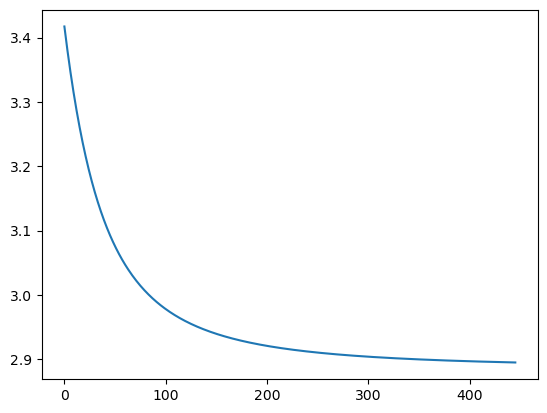

In [43]:
import matplotlib.pyplot as plt
plt.plot(chaser_angles_xy[1:-1])

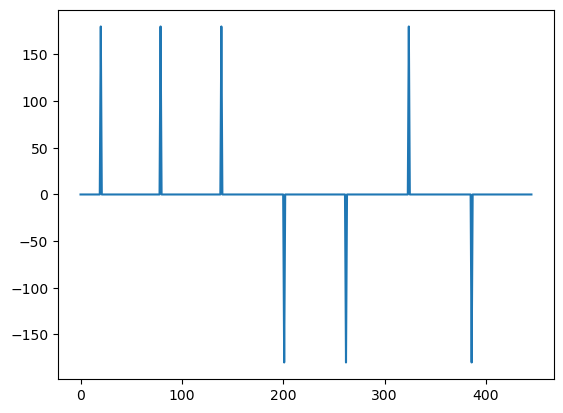

In [42]:
import matplotlib.pyplot as plt
plt.plot(chaser_angles_yz[1:-1])